In [16]:
import numpy as np
import os
import pathlib
import random
import torch
import torchgeometry
import cv2
from dlclive import DLCLive, Processor

import matplotlib.pyplot as plt
from random import randrange
import random
from IPython.display import clear_output

from torch.utils.data import DataLoader

# potential mass parametrizations
from differentiable_robot_model.rigid_body_params import (
    UnconstrainedScalar,
    PositiveScalar,
    UnconstrainedTensor,
)

# potential inertia matrix parametrizations
from differentiable_robot_model.rigid_body_params import (
    CovParameterized3DInertiaMatrixNet,
    Symm3DInertiaMatrixNet,
    SymmPosDef3DInertiaMatrixNet,
    TriangParam3DInertiaMatrixNet,
)

from differentiable_robot_model.robot_model import (
    DifferentiableRobotModel,
    DifferentiableKUKAiiwa,
)
from differentiable_robot_model.data_utils import (
    generate_sine_motion_forward_dynamics_data,
)
import diff_robot_data

torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)


In [17]:
USE_GPU = True
device = torch.device("cpu")
try:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device('cpu')
except:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [18]:
class NMSELoss(torch.nn.Module):
    def __init__(self, var):
        super(NMSELoss, self).__init__()
        self.var = var

    def forward(self, yp, yt):
        err = (yp - yt) ** 2
        werr = err / self.var
        return werr.mean()

class ConstrainedTensor(torch.nn.Module):
    def __init__(self, dim1, dim2, init_tensor=None, init_std=0.1, min_val=0.0, max_val=1.0):
        super().__init__()
        self._dim1 = dim1
        self._dim2 = dim2
        if init_tensor is None:
            init_tensor = torch.empty(dim1, dim2).normal_(mean=0.0, std=init_std)
        self.param = torch.nn.Parameter(init_tensor)
        self.min_val = min_val
        self.max_val = max_val

    def forward(self):
        param = self.param
        param = torch.clamp(param, min=self.min_val, max=self.max_val)
        return param

urdf_path = os.path.join("a1.urdf")
learnable_robot_model = DifferentiableRobotModel(
    urdf_path, "A1", device=device
)

learnable_robot_model.make_link_param_learnable(
    "FR_hip", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
)
learnable_robot_model.make_link_param_learnable(
        "FR_thigh_shoulder", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_thigh", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_calf", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FR_foot", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_hip", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_thigh_shoulder", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_thigh", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_calf", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "FL_foot", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_hip", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_thigh_shoulder", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_thigh", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_calf", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RR_foot", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_hip", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_thigh_shoulder", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_thigh", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_calf", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )
learnable_robot_model.make_link_param_learnable(
        "RL_foot", "trans", ConstrainedTensor(dim1 = 1, dim2 = 3, min_val = 0, max_val = 10)
    )

# learnable_robot_model.print_learnable_params()
joint_angles = torch.rand((1, 12), requires_grad=True).to(device)
learnable_robot_model.compute_forward_kinematics(joint_angles,"FR_foot")

Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_hip_tran']/actuator[@name='FR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_thigh_tran']/actuator[@name='FR_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_calf_tran']/actuator[@name='FR_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_hip_tran']/actuator[@name='FL_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_thigh_tran']/actuator[@name='FL_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_calf_tran']/actuator[@name='FL_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_hip_tran']/actuator[@name='RR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_thigh_tran']/actuator[@name='RR_thigh_motor']
Unknown tag "hardwareInterface" 

(tensor([[ 0.062,  0.145, -0.043]], grad_fn=<AddBackward0>),
 tensor([[0.315, 0.360, 0.131, 0.868]], grad_fn=<CopySlices>))

In [19]:
keypoints = """End of Neck
Shoulder
FL_Knee
FL_Ankle
FL_White_TapeTop
FL_White_TapeBot
FR_Knee
FR_Ankle
FL_Red_TapeTop
FL_Red_TapeBot
End of Tail
Hip
BL_Knee
BL_Ankle
BL_Red_TapeTop
BL_Red_TapeBot
BR_Knee
BR_Ankle
BR_Red_TapeTop
BR_Red_TapeBot""".split("\n")
training_keypoints = ['FL_Ankle','FL_Knee','BL_Ankle','BL_Knee']
indices_keypoints_training = [keypoints.index(val) for val in training_keypoints]

base_dir = pathlib.Path.cwd()
img_path = base_dir / "HorseInferenceFiles/img0088.png"
dlc_model_path = base_dir/"HorseInferenceFiles/DLC_HorseProject1_efficientnet-b0_iteration-0_shuffle-1"
image = cv2.imread(str(img_path))
dlc_proc = Processor()
dlc_live = DLCLive(model_path=str(dlc_model_path), processor=dlc_proc)

out = list()
image_paths = ["img0088.png","img0228.png","img0288.png","img0484.png"]
images = [cv2.imread(str(base_dir / ("HorseInferenceFiles/"+filePath))) for filePath in image_paths ]
batch_size = len(image_paths)
for ind, image in enumerate(images):
    pose = None
    if ind == 0:
        pose = (dlc_live.init_inference(image)[indices_keypoints_training][:,0:2])
    else:
        pose = (dlc_live.get_pose(image)[indices_keypoints_training][:,0:2])
    pose = torch.from_numpy(pose)
    out.append(pose)

# dlc_live.init_inference(image)
# img_keypoints = dlc_live.get_pose(image)

# training_data = img_keypoints[indices_keypoints_training]
# training_data = training_data[:,0:2]
# training_data

training_data = out = torch.stack(out).to(device)
training_data

2023-06-29 10:45:00.348674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 10:45:00.387783: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


tensor([[[275.799, 244.884],
         [249.626, 216.098],
         [340.429, 246.946],
         [349.002, 210.681]],

        [[206.467, 256.802],
         [215.914, 218.328],
         [366.530, 252.797],
         [373.324, 215.444]],

        [[249.048, 258.187],
         [243.911, 220.433],
         [410.155, 250.348],
         [389.190, 213.207]],

        [[252.591, 246.068],
         [225.266, 209.619],
         [339.606, 259.536],
         [349.615, 220.834]]])

In [47]:
def getRobotPositionsFromJointAngles(joint_angles_array, learnable_robot_model):
    """
        Takes in joint angles array and the robot model. Outputs the 3d position of selected joints of the robot given the joint angles.
        Supports batches of joint angles.
    """
    projections = []
    #Where the Robot Thinks It Is
    for joint_angles in joint_angles_array:
        projection = torch.cat((learnable_robot_model.compute_forward_kinematics(joint_angles, "FL_foot")[0],\
        learnable_robot_model.compute_forward_kinematics(joint_angles, "FL_calf")[0],\
        learnable_robot_model.compute_forward_kinematics(joint_angles, "RR_foot")[0],\
        learnable_robot_model.compute_forward_kinematics(joint_angles, "RR_calf")[0]))
        projection = projection.unsqueeze(0).unsqueeze(0)
        projections.append(projection)
    return torch.cat(projections)

def getRobotPositionsInPixelSpace(conversionMatrix, robotPositions):
    """
        Takes in robot positions in 3D space relative to the robot. Then uses the conversion Matrix to figure out where the robot is in the pixel space of the camera. Supports batches of robotPositions.
    """
    return torchgeometry.cam2pixel(robotPositions, conversionMatrix)

def getRobotPositionInCamera(joint_angles_array, conversionMatrix, learnable_robot_model):
    return getRobotPositionsInPixelSpace(conversionMatrix, getRobotPositionsFromJointAngles(joint_angles_array, learnable_robot_model))

In [52]:
intrinsic = torch.Tensor([[1,0,0,np.random.normal(0.0,5.0)],
                          [0,1,0,np.random.normal(0.0,5.0)],
                          [0,0,1,np.random.normal(0.0,5.0)],
                          [0,0,0,1]])
extrinsic = torch.randn((batch_size,4,4))
intrinsic = intrinsic.unsqueeze(0)
intrinsic = intrinsic.detach()
extrinsic = extrinsic.detach()
intrinsic = intrinsic.to(device).requires_grad_(True)
extrinsic = extrinsic.to(device).requires_grad_(True)

Starting Training
Epoch 0: Loss (3293.376953125)


<Figure size 640x480 with 0 Axes>

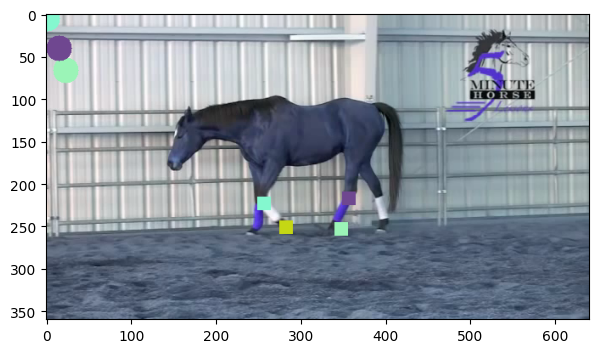

In [55]:
#We initialize joint angles to be the mid point of the upper and lower bound of the joint angles allowed
init_angles = torch.tensor([(joint["upper"] + joint["lower"])/2 for joint in learnable_robot_model.get_joint_limits()])
#We reshape the joint angles to be batch_size,1,#angles. This is so that we have a set of joint angles per image
joint_angles_array = init_angles.unsqueeze(0).unsqueeze(0).repeat(batch_size,1,1)
joint_angles_array = joint_angles_array.detach().clone().to(device).requires_grad_(True)


intrinsic = torch.Tensor([[1.0,0.0,0.0,np.random.normal(0.0,5.0)],
                          [0.0,1.0,0.0,np.random.normal(0.0,5.0)],
                          [0.0,0.0,1.0,np.random.normal(0.0,5.0)],
                          [0.0,0.0,0.0,1.0]])
extrinsic = torch.randn((batch_size,4,4))
intrinsic = intrinsic.unsqueeze(0)
intrinsic = intrinsic.detach()
extrinsic = extrinsic.detach()
intrinsic = intrinsic.to(device).requires_grad_(True)
extrinsic = extrinsic.to(device).requires_grad_(True)

%matplotlib inline
VERBOSE = False

optimizer = torch.optim.Adam([joint_angles_array,intrinsic, extrinsic] + list(learnable_robot_model.parameters()), lr=1e-3)
def debugPrint(*args, **kwargs):
    if VERBOSE:
        print(*args, **kwargs)
print("Starting Training")
for epoch in range(2000000):
    optimizer.zero_grad()
    conversionMatrix = intrinsic @ extrinsic
    cameraEstimate = getRobotPositionInCamera(joint_angles_array, conversionMatrix, learnable_robot_model)
    debugPrint(f"Camera Estimate Shape: {cameraEstimate.shape}")
    
    #Loss Between Where Robot/Horse Should Be and Where It Is
    loss = torch.sum(torch.sqrt(torch.sum(torch.pow((training_data)-cameraEstimate, 2))))


    
    

    if VERBOSE:
        print(f"Epoch {epoch}: Loss ({loss})")
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss ({loss})")

        imgIndex = 0
        img = images[imgIndex].copy()
        random.seed(0)
        size = 15
        for x,y in training_data[imgIndex]:
            color = (randrange(0,256),randrange(0,256),randrange(0,256))
            img = cv2.rectangle(img, (int(x), int(y)),(int(x)+size, int(y)+size), color, -1)
        random.seed(0)
        for x,y in cameraEstimate[imgIndex][0]:
            color = (randrange(0,256),randrange(0,256),randrange(0,256))
            img = cv2.circle(img, (int(x), int(y)), size, color, -1)

        plt.clf()
        plt.figure(figsize=(7,5))
        plt.imshow(img)
        plt.show()
    loss.backward()
    optimizer.step()


TODO:
Init Joint Angles to middle of upper and lower limit.
Rotation google decomposition to rotation/translation for implementation. Idea for simple POC is identity matrix for first 3 columns, then 4th column xyz randomized with z > 0, and xy around 0.
    Extrinsic changes with batch
    Intrinsice stays the same
Remaking code to only go 1 image at a time for now
Add in tests for submodules
Plot the entire robot skeleton